In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data_util
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torchsummary import summary
from sklearn.metrics import r2_score
import math
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)

device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
dhw_merge = pd.read_csv('dhw_merge.csv')
elec_merge  = pd.read_csv('elec_merge.csv')

In [4]:
elec_merge = elec_merge.drop(['YEAR'], axis=1)
dhw_merge = dhw_merge.drop(['YEAR'], axis=1)

In [5]:
dhw_X = dhw_merge.drop(['DHW'], axis=1)
dhw_Y = dhw_merge[['DHW']]

scaler_dhw = MinMaxScaler()
scaler_dhw.fit(dhw_X)
scaled_dhw_X = scaler_dhw.transform(dhw_X)

new_dhw_X = pd.DataFrame(scaled_dhw_X, index=dhw_X.index, columns=dhw_X.columns)
new_dhw = pd.concat([new_dhw_X, dhw_Y], axis=1)

In [6]:
elec_X = elec_merge.drop(['ELEC'], axis=1)
elec_Y = elec_merge[['ELEC']]

scaler_elec = MinMaxScaler()
scaler_elec.fit(elec_X)
scaled_elec_X = scaler_elec.transform(elec_X)

new_elec_X = pd.DataFrame(scaled_elec_X, index=elec_X.index, columns=elec_X.columns)
new_elec = pd.concat([new_elec_X, elec_Y], axis=1)

In [7]:
input_dhw = new_dhw.iloc[:-1,]
target_dhw = new_dhw[['DHW']].iloc[1:]

trainX_dhw, testX_dhw, trainY_dhw, testY_dhw = train_test_split(input_dhw,target_dhw,test_size=0.3,shuffle=False,random_state=0)

In [8]:
input_elec = new_elec.iloc[:-1,]
target_elec = new_elec[['ELEC']].iloc[1:]

trainX_elec, testX_elec, trainY_elec, testY_elec = train_test_split(input_elec,target_elec,test_size=0.3,shuffle=False,random_state=0)

In [9]:
seqLength = 24
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [10]:
trainx_dhw, trainy_dhw = buildDataSet(trainX_dhw, trainY_dhw, 24)
testx_dhw, testy_dhw = buildDataSet(testX_dhw, testY_dhw, 24)
trainx_elec, trainy_elec = buildDataSet(trainX_elec, trainY_elec, 24)
testx_elec, testy_elec = buildDataSet(testX_elec, testY_elec, 24)

In [11]:
# 텐서로 변환
elec_trainx_tensor = torch.FloatTensor(trainx_elec)
elec_trainy_tensor = torch.FloatTensor(trainy_elec)

elec_testx_tensor = torch.FloatTensor(testx_elec)
elec_testy_tensor = torch.FloatTensor(testy_elec)

dhw_trainx_tensor = torch.FloatTensor(trainx_dhw)
dhw_trainy_tensor = torch.FloatTensor(trainy_dhw)

dhw_testx_tensor = torch.FloatTensor(testx_dhw)
dhw_testy_tensor = torch.FloatTensor(testy_dhw)

In [12]:
# 텐서 형태로 데이터 정의
elec_train = TensorDataset(elec_trainx_tensor, elec_trainy_tensor)
elec_test = TensorDataset(elec_testx_tensor, elec_testy_tensor)

dhw_train = TensorDataset(dhw_trainx_tensor, dhw_trainy_tensor)
dhw_test = TensorDataset(dhw_testx_tensor, dhw_testy_tensor)

In [13]:
batch_for_elec_train = 1024
batch_for_elec_test = 1024
batch_for_dhw_train = 1024
batch_for_dhw_test = 1024

ELEC_train = DataLoader(elec_train,
                        batch_size=batch_for_elec_train,
                        shuffle=False,  
                        drop_last=False)

ELEC_test = DataLoader(elec_test,
                        batch_size=batch_for_elec_test,
                        shuffle=False,  
                        drop_last=False)

DHW_train = DataLoader(dhw_train,
                        batch_size=batch_for_dhw_train,
                        shuffle=False,  
                        drop_last=True)

DHW_test = DataLoader(dhw_test,
                        batch_size=batch_for_dhw_test,
                        shuffle=False,  
                        drop_last=True)

In [14]:
# 데이터셋의 개수를 가정하여 변수에 저장
elec_train_size = len(elec_train)
elec_test_size = len(elec_test)
dhw_train_size = len(dhw_train)
dhw_test_size = len(dhw_test)

# 각 DataLoader에서 생성되는 배치의 개수 계산
elec_train_batches = math.ceil(elec_train_size / batch_for_elec_train)
elec_test_batches = math.ceil(elec_test_size / batch_for_elec_test)
dhw_train_batches = math.ceil(dhw_train_size / batch_for_dhw_train)
dhw_test_batches = math.ceil(dhw_test_size / batch_for_dhw_test)

# 결과 출력
print("elec_train batches:", elec_train_batches)
print("elec_test batches:", elec_test_batches)
print("dhw_train batches:", dhw_train_batches)
print("dhw_test batches:", dhw_test_batches)

elec_train batches: 3
elec_test batches: 2
dhw_train batches: 20
dhw_test batches: 9


# 모델 구조 선언

In [15]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [16]:
class Seq2SeqModel(nn.Module):
    def __init__(self):
        super(Seq2SeqModel, self).__init__()
        
        # for feature extracting
        self.conv1 = nn.Conv1d(12, 64, kernel_size=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        self.conv3 = nn.Conv1d(32, 128, kernel_size=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        
        # Encoder
        self.encoder1 = nn.LSTM(128, 64, batch_first=True, bias=False)
        self.encoder2 = nn.LSTM(64, 32, batch_first=True, bias=False)
        self.encoder3 = nn.LSTM(32, 128, batch_first=True, bias=False)
        
        # Decoder
        self.decoder1 = nn.LSTM(128, 128, batch_first=True, bias=False)
        self.decoder2 = nn.LSTM(128, 32, batch_first=True, bias=False)
        self.decoder3 = nn.LSTM(32, 64, batch_first=True, bias=False)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(24 * 64, 1)
        self.tanh = nn.Tanh()
        self.swish = Swish()
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = x.transpose(2,1)
        x = self.swish(x)
        x = self.pool1(x)
        x = F.pad(x, (0, 1), 'replicate', 0)
        
        x = x.transpose(1,2)
        x = self.conv2(x)
        x = x.transpose(2,1)
        x = self.swish(x)
        x = self.pool2(x)
        x = F.pad(x, (0, 1), 'replicate', 0)
        
        x = x.transpose(1,2)
        x = self.conv3(x)
        x = x.transpose(2,1)
        x = self.swish(x)
        x = self.pool3(x)
        x = F.pad(x, (0, 1), 'replicate', 0)
        
        #x = x.transpose(2,1)
        x, _ = self.encoder1(x)
        x = self.tanh(x)
        x, _ = self.encoder2(x)
        x = self.tanh(x)
        x, (h, c) = self.encoder3(x)
        x = self.tanh(x)
        x, _ = self.decoder1(x, (h, c))
        x = self.tanh(x)
        x, _ = self.decoder2(x)
        x = self.tanh(x)
        x, _ = self.decoder3(x)
        x = self.tanh(x)
        x = x.reshape(-1, 64 * 24)
        x = self.dense(x)
        x = self.swish(x)
        return x

In [17]:
class seq_loss(nn.Module):
    def __init__(self):
        super(seq_loss, self).__init__()
        self.reg = nn.L1Loss()
        
    def forward(self, result, real):
        x = result
        loss = self.reg(x, real)
        
        return loss

In [18]:
# hoxy = Seq2SeqModel()
# inputx = torch.randn(512,24,12)
# hoxy2 = hoxy(inputx)
# print(hoxy2.shape)

In [19]:
model = Seq2SeqModel().to(device)
loss_fn = seq_loss().to(device)

In [20]:
from torchinfo import summary

summary(model, (1024,24,12))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2SeqModel                             [1024, 1]                 --
├─Conv1d: 1-1                            [1024, 64, 24]            832
├─Swish: 1-2                             [1024, 24, 64]            --
│    └─Sigmoid: 2-1                      [1024, 24, 64]            --
├─MaxPool1d: 1-3                         [1024, 24, 63]            --
├─Conv1d: 1-4                            [1024, 32, 24]            2,080
├─Swish: 1-5                             [1024, 24, 32]            --
│    └─Sigmoid: 2-2                      [1024, 24, 32]            --
├─MaxPool1d: 1-6                         [1024, 24, 31]            --
├─Conv1d: 1-7                            [1024, 128, 24]           4,224
├─Swish: 1-8                             [1024, 24, 128]           --
│    └─Sigmoid: 2-3                      [1024, 24, 128]           --
├─MaxPool1d: 1-9                         [1024, 24, 127]           --
├─LSTM: 

In [21]:
from torch.optim.lr_scheduler import LinearLR

# 손실 함수와 옵티마이저 정의
epochs = 1000
model.train()

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.01)
#scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters = epochs * len(ELEC_train))

patience = 400  # Early stopping을 위한 기다리는 최대 epoch 수
best_loss = float('inf')
best_model_state_dict = None
counter = 0  # Early stopping 카운터

# 모델 학습
model.train() # 훈련 모드 설정

for epoch in range(epochs):
    running_loss = 0
    for step, samples in enumerate(ELEC_train):
        inputs = samples[0].to(device)
        targets = samples[1].to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        running_loss += loss.item()
        # 그래디언트 계산 및 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
    
    # early stopping 및 모델 저장
    if running_loss / len(ELEC_train) < best_loss:
        best_loss = running_loss / len(ELEC_train)
        best_model_state_dict = model.state_dict()
        counter = 0  # Counter 초기화
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    print('Epoch : %d, Loss : %.4f' % (epoch, running_loss / len(ELEC_train)))     
    print('')

# 최상의 모델을 파일로 저장
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, '0919_seq2seq_pytorch_fail.pth')

Epoch : 0, Loss : 0.6157

Epoch : 1, Loss : 0.6142

Epoch : 2, Loss : 0.6127

Epoch : 3, Loss : 0.6112

Epoch : 4, Loss : 0.6097

Epoch : 5, Loss : 0.6082

Epoch : 6, Loss : 0.6067

Epoch : 7, Loss : 0.6052

Epoch : 8, Loss : 0.6037

Epoch : 9, Loss : 0.6021

Epoch : 10, Loss : 0.6006

Epoch : 11, Loss : 0.5991

Epoch : 12, Loss : 0.5975

Epoch : 13, Loss : 0.5960

Epoch : 14, Loss : 0.5944

Epoch : 15, Loss : 0.5929

Epoch : 16, Loss : 0.5913

Epoch : 17, Loss : 0.5898

Epoch : 18, Loss : 0.5882

Epoch : 19, Loss : 0.5866

Epoch : 20, Loss : 0.5850

Epoch : 21, Loss : 0.5835

Epoch : 22, Loss : 0.5819

Epoch : 23, Loss : 0.5803

Epoch : 24, Loss : 0.5787

Epoch : 25, Loss : 0.5771

Epoch : 26, Loss : 0.5755

Epoch : 27, Loss : 0.5739

Epoch : 28, Loss : 0.5723

Epoch : 29, Loss : 0.5707

Epoch : 30, Loss : 0.5690

Epoch : 31, Loss : 0.5674

Epoch : 32, Loss : 0.5658

Epoch : 33, Loss : 0.5642

Epoch : 34, Loss : 0.5625

Epoch : 35, Loss : 0.5609

Epoch : 36, Loss : 0.5592

Epoch : 37,

In [22]:
# 모델의 가중치를 출력
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv1.weight tensor([[[-2.4242e-43],
         [ 2.1040e-40],
         [-5.5351e-43],
         [ 5.3530e-43],
         [ 2.6064e-43],
         [-2.6765e-43],
         [ 6.8664e-44],
         [-3.5733e-43],
         [ 7.4409e-43],
         [-6.8804e-43],
         [ 6.4740e-43],
         [ 6.4039e-43]],

        [[-2.2981e-43],
         [ 7.1975e-41],
         [-4.2039e-45],
         [-4.2740e-43],
         [-2.7764e-39],
         [ 4.9746e-43],
         [-2.3724e-42],
         [ 7.2447e-43],
         [-2.9708e-43],
         [-9.6022e-40],
         [-7.3008e-43],
         [-1.2677e-37]],

        [[-2.4803e-43],
         [ 5.1988e-43],
         [ 2.8727e-43],
         [-7.1887e-43],
         [-3.0548e-43],
         [ 7.6371e-43],
         [-2.8815e-41],
         [ 5.8855e-43],
         [-1.4812e-42],
         [-7.5390e-43],
         [-7.9313e-43],
         [-2.5392e-42]],

        [[-9.5288e-43],
         [ 1.9618e-43],
         [-3.8255e-43],
         [-8.7161e-43],
         [-1.0103e-42

In [23]:
best_model = Seq2SeqModel().to(device)
best_model.load_state_dict(torch.load('0919_seq2seq_pytorch_fail.pth'))
best_model.eval()

train_pred_list = []
train_output_list = []

for step, samples in enumerate(ELEC_train):
    inputs = samples[0].to(device)
    targets = samples[1].to(device)
    #print(inputs)
    pred = best_model(inputs)
    
    train_output_list.extend(targets.detach().cpu().numpy())
    train_pred_list.extend(pred.detach().cpu().numpy())
    
r2 = r2_score(train_output_list, train_pred_list)
print('r2 score', r2)

r2 score -0.031160960564814655


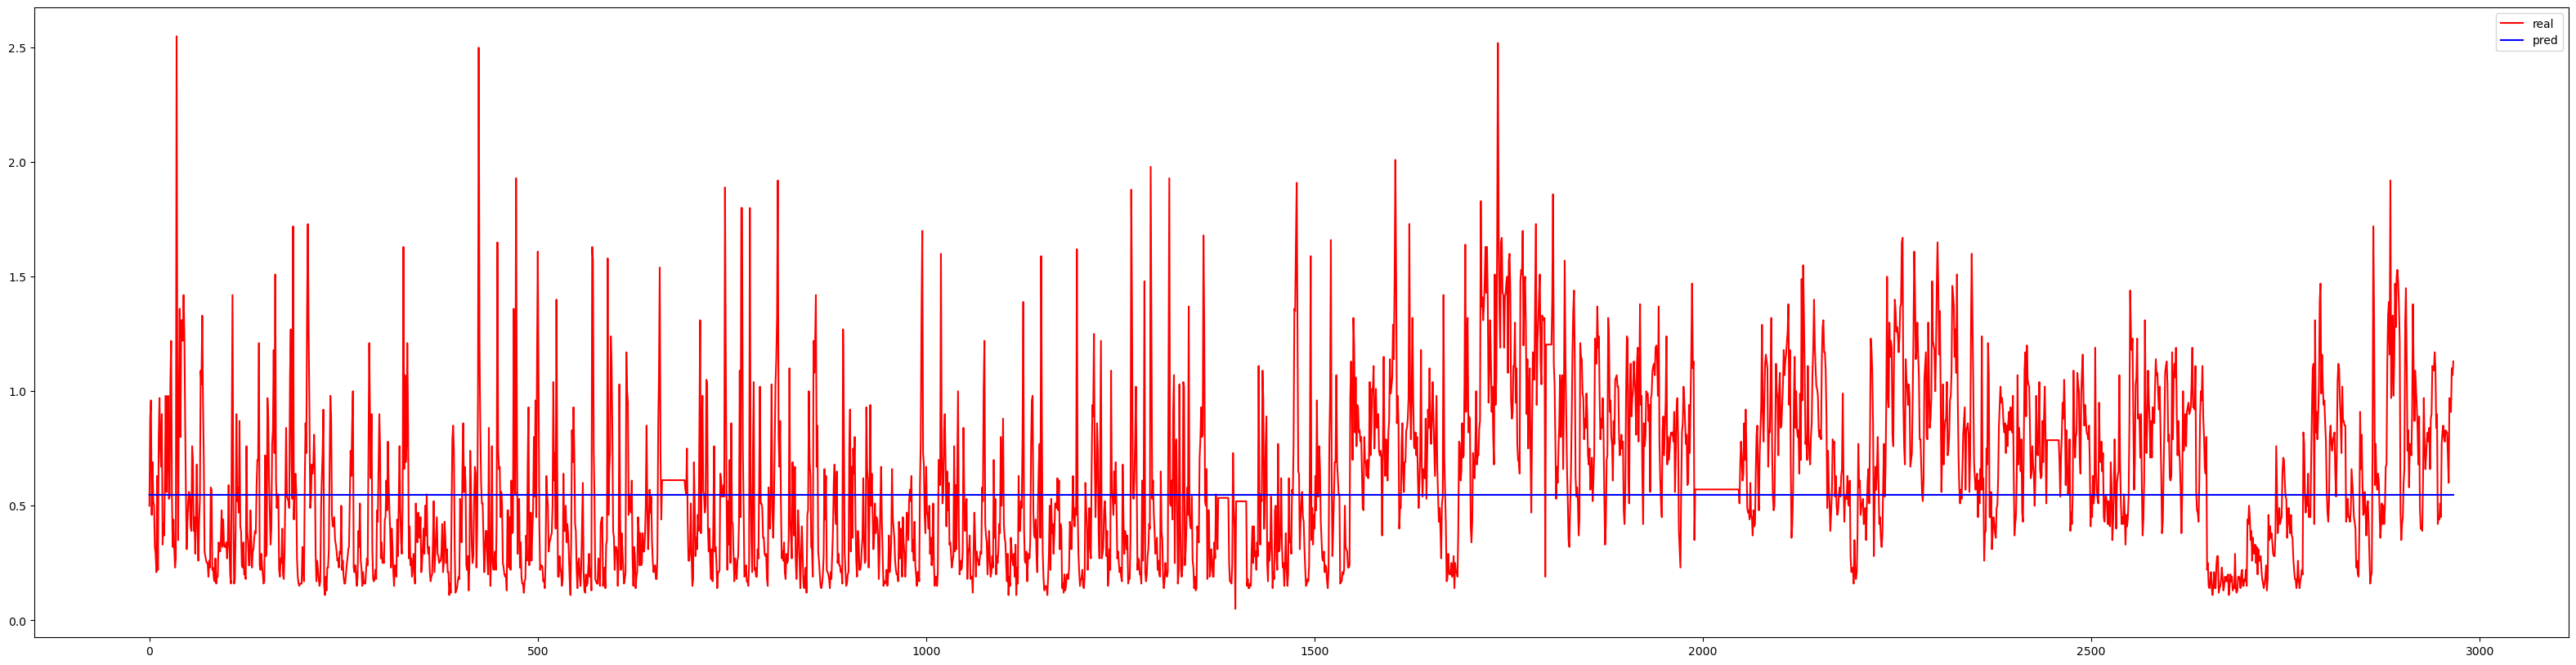

In [24]:
plt.figure(figsize=(40,10))
plt.plot(train_output_list, color='red', label='real')
plt.plot(train_pred_list, color='blue', label='pred')
plt.legend()
plt.show()

In [25]:
best_model = Seq2SeqModel().to(device)
best_model.load_state_dict(torch.load('0919_seq2seq_pytorch_fail.pth'))
best_model.eval()

test_pred_list = []
test_output_list = []
for step, samples in enumerate(ELEC_test):
    inputs = samples[0].to(device)
    targets = samples[1].to(device)
    
    pred = best_model(inputs)
    
    test_output_list.extend(targets.detach().cpu().numpy())
    test_pred_list.extend(pred.detach().cpu().numpy())
r2 = r2_score(test_output_list, test_pred_list)
print('r2 score', r2)

r2 score -0.5847194789775629


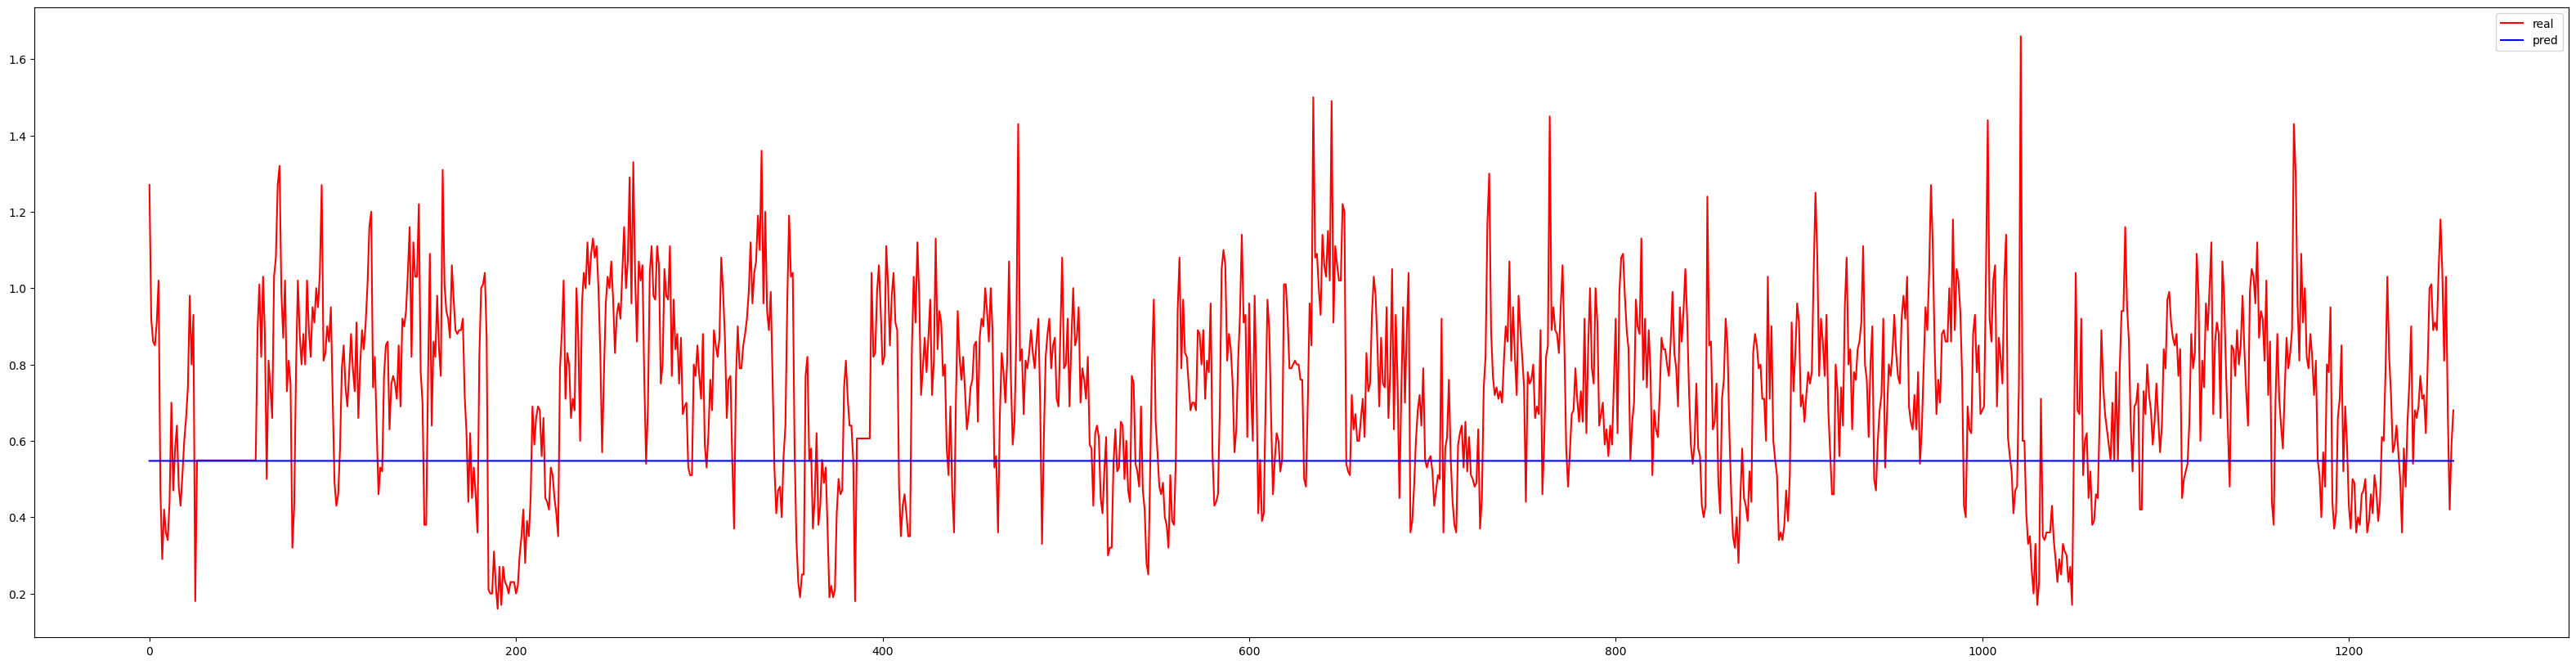

In [26]:
plt.figure(figsize=(40,10))
plt.plot(test_output_list, color='red', label='real')
plt.plot(test_pred_list, color='blue', label='pred')
plt.legend()
plt.show()

In [27]:
# class Seq2SeqModel(nn.Module):
#     def __init__(self):
#         super(Seq2SeqModel, self).__init__()
#         self.decoder2 = nn.LSTM(12, 32, batch_first=True, bias=False)
#         self.decoder3 = nn.LSTM(32, 64, batch_first=True, bias=False)
        
#         self.flatten = nn.Flatten()
#         self.dense = nn.Linear(24*64, 1)
#         self.tanh = nn.Tanh()
#         self.swish = Swish()
        
#     def forward(self, x):
#         x, _ = self.decoder2(x)
#         x = self.tanh(x)
#         x, _ = self.decoder3(x)
#         x = self.tanh(x)
#         x = x.reshape(-1, 24*64)
#         x = self.dense(x)
#         x = self.swish(x)
#         return x

In [28]:
# model2 = Seq2SeqModel().to(device)

In [29]:
# from torchinfo import summary

# summary(model2, (1024,24,12))